In [1]:
%matplotlib inline
import time
import numpy as np
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.interpolate import *
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
import os, sys
from time import sleep, monotonic
from scipy.ndimage import gaussian_filter

import qcodes as qc
from qcodes import Parameter
from qcodes import initialise_or_create_database_at
from qcodes import load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter

sys.path.append('M:\\tnw\\ns\\qt\\2D Topo\\code\\qcodes')

In [2]:
dirpath = os.getcwd()
sample_name = dirpath.split('\\')[-2]
wafer_name = dirpath.split('\\')[-3]
db_path = dirpath.rsplit('\\', 1)[0] + '\\data'

In [3]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(db_path):
    for file in f:
        if '.db' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f)

M:\tnw\ns\qt\2D Topo\samples\InSb_epiAl\M06-12-18.1_2\33\data\M06-12-18.1_2_33_2020-11-26_01.db
M:\tnw\ns\qt\2D Topo\samples\InSb_epiAl\M06-12-18.1_2\33\data\M06-12-18.1_2_33_2020-12-04_01.db


In [4]:
db_path = os.path.join(db_path, 'M06-12-18.1_2_33_2020-11-26_01.db')
initialise_or_create_database_at(db_path)

In [5]:
import matplotlib

In [6]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Smooth dirivative

In [6]:
def smooth_dir(parametr, N_points = 5):
    
    #parametr => current_DC
    #Ny => Ngate
    #Nx => Nvolt
    
    Ny = parametr.shape[0]
    Nx = parametr.shape[1]
    
    d_parameter = np.zeros_like(parametr)
    
    for y_idx in range(Ny): #for each gate value
        for x_idx in range (Nx): #for each voltage point
            vals_to_fit = parametr[y_idx, max(0,x_idx-N_points):min(Nx, x_idx+N_points)] #select current values to fit
            x_axes = np.arange(vals_to_fit.size) #array from 0 to 2*Npoints+1 of integers (fitting length)
            fit_vals = np.polyfit(x_axes, vals_to_fit, 1) #directly use x_axes, because we take derivative with step
            d_parameter[y_idx, x_idx] = fit_vals[0] #derivative with respect to index
            
    return d_parameter

# Loading data

In [7]:
qc.experiments()

[I_vs_Vtg#JJ1_JJ1#1@M:\tnw\ns\qt\2D Topo\samples\InSb_epiAl\M06-12-18.1_2\33\data\M06-12-18.1_2_33_2020-11-26_01.db
 ------------------------------------------------------------------------------------------------------------------
 1-results-1-appl_TG,meas_current_K1,meas_leakage-440,
 I_vs_Vtg#JJ1_JJ1#2@M:\tnw\ns\qt\2D Topo\samples\InSb_epiAl\M06-12-18.1_2\33\data\M06-12-18.1_2_33_2020-11-26_01.db
 ------------------------------------------------------------------------------------------------------------------
 2-results-1-appl_TG,meas_current_K1,meas_leakage-1000,
 I_vs_Vgate_up#JJ1_JJ1#3@M:\tnw\ns\qt\2D Topo\samples\InSb_epiAl\M06-12-18.1_2\33\data\M06-12-18.1_2_33_2020-11-26_01.db
 -----------------------------------------------------------------------------------------------------------------------
 3-results-1-appl_TG,meas_current_K1-400,
 I_vs_Vgate_down#JJ1_JJ1#4@M:\tnw\ns\qt\2D Topo\samples\InSb_epiAl\M06-12-18.1_2\33\data\M06-12-18.1_2_33_2020-11-26_01.db
 -----------------

IV vs B


([<matplotlib.axes._subplots.AxesSubplot at 0x2af16a37e10>,
  <matplotlib.colorbar.Colorbar at 0x2af18b58ac8>])

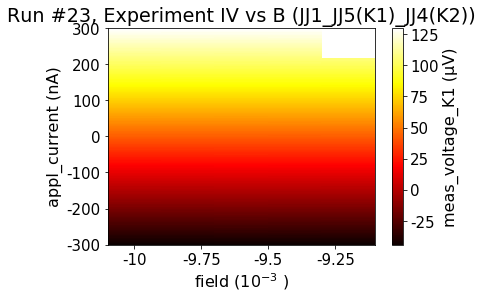

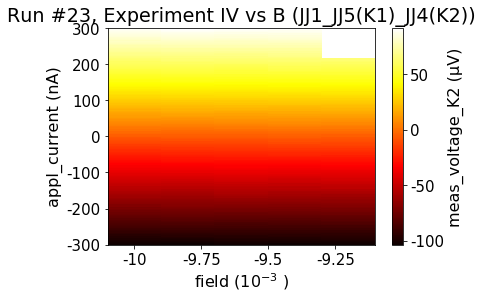

In [8]:
dataset = qc.load_by_id(23)
print(dataset.exp_name)
cmap = plt.get_cmap('hot')
axes = plot_dataset(dataset, cmap = cmap)
axes
#plt.savefig('../plots/TL2_JJL_IV_1.png')

## Get R from slop

In [ ]:
dataset = qc.load_by_id(32)
voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
fit_values = np.polyfit(current,voltage,1)
print(np.abs(fit_values[0]))

In [ ]:
dataset = qc.load_by_id(9)
dataset.get_parameter_data()['meas_voltage_K1'].keys()

## IV vs time

In [ ]:
dataset = qc.load_by_id(9)
voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
time = dataset.get_parameter_data()['meas_voltage_K1']['time']

N_time = np.size(np.unique(time))
N_current = np.size(np.unique(current))

if np.size(voltage) < N_time * N_current:
    print('Interupted scan! Last sweep is disregarded')
    N_time = N_time - 1
    voltage = voltage[0:N_time * N_current]
    current = current[0:N_time * N_current]
    time = time[0:N_time * N_current]
    

voltage = -1*voltage.reshape(N_time, N_current)
current = current.reshape(N_time, N_current)
time = time.reshape(N_time, N_current)

dif_voltage = np.diff(voltage, axis = 1)
dif_current = np.diff(current, axis = 1)
R = dif_voltage/dif_current
difdif_voltage = np.diff(dif_voltage, axis = 1)
R_filt = gaussian_filter( R, sigma=(0.1,1))

In [ ]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')
im = ax.pcolormesh(time/60, 1e9 * current, R_filt, cmap = cmap, vmin = 0)
fig.colorbar(im,ax=ax)
#ax.set_ylim(-100, 100)
#ax.set_xlim(-2, 2)
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Time (min)')
#plt.savefig('../plots/R(I,B)_J1.png')
plt.show()

## IV vs gate

In [86]:
dataset = qc.load_by_id(28)
voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
v_gate = dataset.get_parameter_data()['meas_voltage_K1']['appl_TG']

N_gate = np.size(np.unique(v_gate))
N_current = np.size(np.unique(current))

if np.size(voltage) < N_gate * N_current:
    N_gate = N_gate - 1
    voltage = voltage[0:N_gate * N_current]
    current = current[0:N_gate * N_current]
    v_gate = v_gate[0:N_gate * N_current]
    

voltage = voltage.reshape(N_gate, N_current)
current = current.reshape(N_gate, N_current)
v_gate = v_gate.reshape(N_gate, N_current)

dif_voltage = np.diff(voltage, axis = 1)
dif_current = np.diff(current, axis = 1)
R = dif_voltage/dif_current
difdif_voltage = np.diff(dif_voltage, axis = 1)
R_filt = gaussian_filter( R, sigma=(0.1,2))

I_step = current[0,1] - current[0,0]
R_sm = smooth_dir(voltage, N_points=6) / I_step #scale the derivative

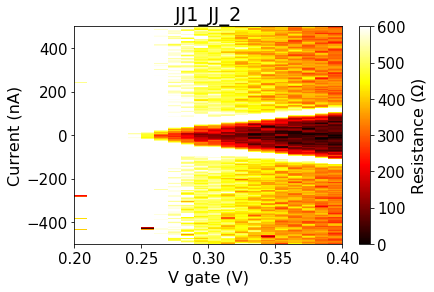

In [88]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')
im = ax.pcolormesh(v_gate, 1e9 * current, R_sm, cmap = cmap, vmin=0,vmax=600)
cbar = fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)
# ax.set_xlim(-10, 10)
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'V gate (V)')
cbar.set_label(r'Resistance ($\Omega$)', rotation=90)
plt.title('JJ1_JJ_2')
plt.savefig('../plots/R(I,Vg)_JJ1_JJ_2.png')
plt.show()

## IV vs B

In [15]:
dataset = qc.load_by_id(25)
dataset.get_parameter_data()['meas_voltage_K2'].keys()

dict_keys(['meas_voltage_K2', 'cryomag_A_field', 'appl_current'])

In [63]:
dataset = qc.load_by_id(27)
voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
field = dataset.get_parameter_data()['meas_voltage_K1']['cryomag_A_field']

N_field = np.size(np.unique(field))
N_current = np.size(np.unique(current))

if np.size(voltage) < N_field * N_current:
    N_field = N_field - 1
    voltage = voltage[0:N_field * N_current]
    current = current[0:N_field * N_current]
    field = field[0:N_field * N_current]
    

voltage = voltage.reshape(N_field, N_current)
current = current.reshape(N_field, N_current)
field = field.reshape(N_field, N_current)

dif_voltage = np.diff(voltage, axis = 1)
dif_current = np.diff(current, axis = 1)
R = dif_voltage/dif_current
difdif_voltage = np.diff(dif_voltage, axis = 1)
R_filt = gaussian_filter( R, sigma=(0,1))

I_step = current[0,1] - current[0,0]
R_sm = smooth_dir(voltage, N_points=6) / I_step #scale the derivative

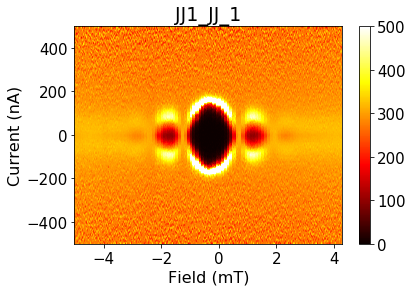

In [64]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')

pixel_width = field[1,0]-field[0,0]
pixel_height = current[0,1]-current[0,0]

im = ax.pcolormesh(1e3*(field-pixel_width/2), 1e9 * (current-pixel_height/2), 
                   R_sm, cmap = cmap, vmin=0,vmax=500)
fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)\
# ax.set_xlim(-2, 2)
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Field (mT)')
plt.title('JJ1_JJ_1')
plt.savefig('../plots/R(I,B)_JJ1_JJ_1_b.png')
plt.show()

## Finding Ic and offset

In [65]:
difdif_voltage = gaussian_filter( np.diff( gaussian_filter(R_filt, sigma=(0.1,1)), axis = 1), sigma=(0.1,2))

#shape matching due to derivative
field_cut = 1e3 * field[:,0:-2]
current_cut = 1e9 * current[:,0:-2]


#row and coulumn masks
mask_B =  (( field_cut > -1 ) & ( field_cut < 0.5 ) )[:,1]
mask_I = (( current_cut > -300 ) & ( current_cut < 10 ) )[1,:]

field_masked = field_cut[:,mask_I]
field_masked = field_masked[mask_B,:]

current_masked = current_cut[:,mask_I]
current_masked = current_masked[mask_B,:]

difdif_voltage_masked = difdif_voltage[:,mask_I]
difdif_voltage_masked = difdif_voltage_masked[mask_B,:]

R_filt_cut = R_filt[:,0:-1]
R_filt_masked = R_filt_cut[:,mask_I]
R_filt_masked = R_filt_masked[mask_B,:]

### Peaks extraction in $\frac{d^2 V}{dI^2}$

In [66]:
B_vals = field_masked[:,1]
I_vals = current_masked[1,:]
peak_positions = np.zeros_like(B_vals)

for B_idx, B in enumerate(B_vals):
    d2V_dI2 = -1*difdif_voltage_masked[B_idx, 10:-1]
    I_vals_cut = I_vals[10:-1]
    prominance = 1000
    peaks = find_peaks(d2V_dI2, prominence=prominance)
    while np.size(peaks[0])==0:
#         print('no peaks')
        prominance -=2
        peaks = find_peaks(d2V_dI2, prominence=prominance)
#     print(peaks[0])
    
#     if np.size(peaks[0]) > 1:
#         fig, ax = plt.subplots()
#         ax.plot(I_vals_cut, d2V_dI2)
#         ax.scatter(I_vals_cut[peaks[0]], d2V_dI2[peaks[0]])
#         plt.show()
#         break
        
    if np.size(peaks[0]) > 1:
        peak_positions[B_idx] =  I_vals_cut[peaks[0][np.argmax(peaks[1]['prominences'])]]
    else:
        peak_positions[B_idx] =  I_vals_cut[peaks[0]] if len(peaks[0])>0 else 0
        
#     if np.abs(peak_positions[B_idx]) > 200:
#         fig, ax = plt.subplots()
#         ax.plot(I_vals_cut, d2V_dI2)
#         ax.scatter(I_vals_cut[peaks[0]], d2V_dI2[peaks[0]])
#         plt.show()
#         break
        
    
#     fig, ax = plt.subplots()
#     ax.plot(I_vals_cut, d2V_dI2)
#     ax.scatter(I_vals_cut[peaks[0]], d2V_dI2[peaks[0]])
#     plt.show()
#     break

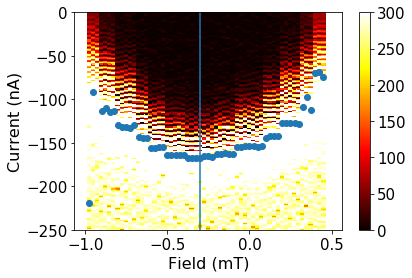

In [73]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')
pixel_width = field_masked[1,0]-field_masked[0,0]
pixel_height = current_masked[0,1]-current_masked[0,0]

im = ax.pcolor(field_masked - pixel_width/2, current_masked - pixel_height/2, R_filt_masked, cmap = cmap, vmin= 0, vmax = 300)
fig.colorbar(im,ax=ax)
ax.scatter(B_vals, peak_positions)
ax.set_ylim(-250, 0)
#ax.set_xlim(-0.6, -0.1)
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Field (mT)')
ax.axvline(-0.3)
plt.show()

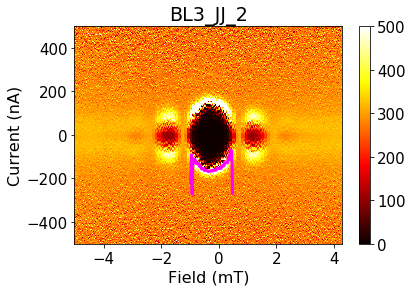

In [68]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')

pixel_width = field[1,0]-field[0,0]
pixel_height = current[0,1]-current[0,0]

im = ax.pcolormesh(1e3*(field-pixel_width/2), 1e9 * (current-pixel_height/2), 
                   R_filt, cmap = cmap, vmin=0,vmax=500)
fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)\
# ax.set_xlim(-2, 2)

ax.plot(B_vals, peak_positions, linewidth = 3, color = 'magenta')

ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Field (mT)')
plt.title('BL3_JJ_2')
# plt.savefig('../plots/R(I,B)_BL3_JJ_2.png')
plt.show()

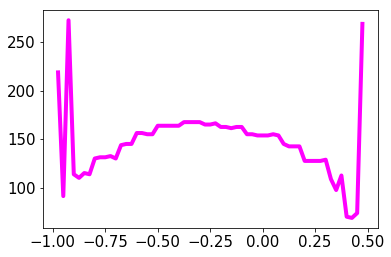

In [69]:
fig, ax = plt.subplots()

ax.plot(B_vals, -peak_positions, linewidth = 4, color = 'magenta')


plt.show()

## MAR data

In [175]:
dataset = qc.load_by_id(36)
voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']

lockin = dataset.get_parameter_data()['meas_voltage_R_Lockin1']['meas_voltage_R_Lockin1']
current_AC = dataset.snapshot['station']['parameters']['appl_current_AC']['value']

R_AC = lockin/current_AC

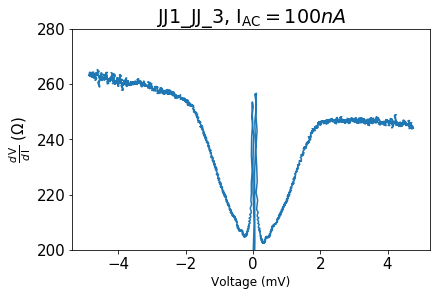

In [176]:
fig, ax = plt.subplots(constrained_layout = True)
# ax.plot(1e3*voltage[0:-1], R_filt)
# ax.plot(1e3*voltage, R_filt)
ax.plot(1e3*voltage, gaussian_filter(R_AC, sigma=(1)))

ax.set_ylim(200, 280)
# ax.set_ylim(210, 250)
# ax.set_xlim(-2, 2)
ax.set_ylabel(r'$\frac{d \: \mathrm{V}}{d \: \mathrm{I}}$ ($\Omega$)', fontsize = 15)
ax.set_xlabel(r'Voltage (mV)', fontsize = 12)
plt.title('JJ1_JJ_3, $\mathrm{I}_\mathrm{AC} = 100 nA$')
# plt.legend()
plt.savefig('../plots/JJ1_JJ_3_MAR.png')

In [177]:
I_range = 15e-6

I_to_fit_l = current[current < -I_range]
V_to_fit_l = voltage[current < -I_range]

I_to_fit_r = current[current > I_range]
V_to_fit_r = voltage[current > I_range]

fit_vals_l = np.polyfit(I_to_fit_l, V_to_fit_l, 1)
fit_vals_r = np.polyfit(I_to_fit_r, V_to_fit_r, 1)

R_N = (fit_vals_l[0] + fit_vals_r[0])/2

I_exs_l = -fit_vals_l[1] / fit_vals_l[0]
I_exs_r = -fit_vals_r[1] / fit_vals_r[0]

I_exs = (I_exs_r - I_exs_l)/2

In [178]:
print(I_exs * R_N * 1e3)
print(I_exs * R_N * 1e3 / 0.49)

0.304771288822
0.621982222085


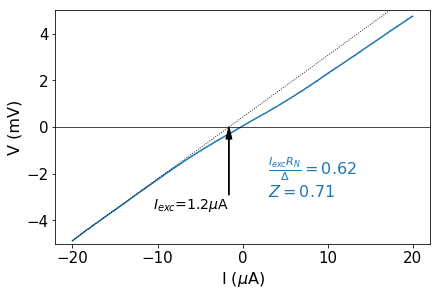

In [191]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout = True)
# ax.plot(1e3*voltage[0:-1], R_filt)
# ax.plot(1e3*voltage, R_filt)
ax.plot(1e6*current, 1e3*gaussian_filter(voltage, sigma=(1)))

ax.plot(1e6*current, 1e3*(current*fit_vals_l[0]+fit_vals_l[1]), linestyle = ':', color= 'black',linewidth = 0.9)

ax.axhline(0, linestyle = '-', color= 'black',linewidth = 0.7)

ax.set_xlabel(r'I ($\mu$A)', fontsize = 16)
ax.set_ylabel(r'V (mV)', fontsize = 16)

# plt.title('')

ax.set_ylim(-5, 5)
# ax.set_xlim(-15, 15)

# # inset axes....
# axins = ax.inset_axes([0.05, 0.65, 0.3, 0.3])
# axins.plot(1e6*current, 1e3*gaussian_filter(voltage, sigma=(1)))
# # sub region of the original image
# x1, x2, y1, y2 = -0.3, 0.3, -0.1, 0.1
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# # axins.set_xticklabels('')
# axins.set_yticklabels('')
# plt.setp(axins.get_xticklabels(), fontsize=10)

# ax.indicate_inset_zoom(axins)

ax.annotate(r'$I_{exc}$='+'{:.1f}'.format(1e6*I_exs)+r'$\mu$A', xy=(1e6*I_exs_l, 0),  xycoords='data',
            xytext=(1e6*I_exs_l, -3), textcoords='data',
            arrowprops=dict(facecolor='black', width=0.1, headwidth = 6),
            horizontalalignment='right', verticalalignment='top',fontsize = 14
            )

ax.text(3, -2, r'$\frac{I_{exc}R_N}{\Delta} = 0.62 $', {'color': 'C0', 'fontsize': 16})
ax.text(3, -3, r'$Z = 0.71 $', {'color': 'C0', 'fontsize': 16})
plt.savefig('../plots/JJ1_JJ_3_MAR_1.png', transparency = True)

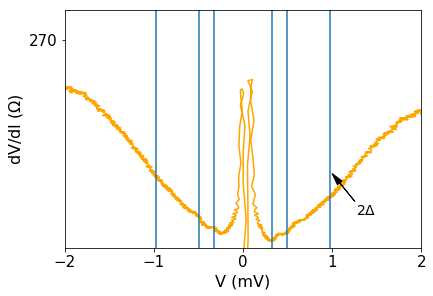

In [190]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout = True)
# ax.plot(1e3*voltage[0:-1], R_filt)
# ax.plot(1e3*voltage, R_filt)
ax.plot(1e3*voltage, gaussian_filter(R_AC, sigma=(1)), color = 'orange' )

# ax.axhline(0, linestyle = '-', color= 'black',linewidth = 0.7)

ax.set_ylabel(r'dV/dI ($\Omega$)', fontsize = 16)
ax.set_xlabel(r'V (mV)', fontsize = 16)

# plt.title('')



ax.annotate(r'$2\Delta$', xy=(1, 225),  xycoords='data',
            xytext=(1.5, 215), textcoords='data',
            arrowprops=dict(facecolor='black', width=0.1, headwidth = 6),
            horizontalalignment='right', verticalalignment='top',fontsize = 14
            )

ax.yaxis.set_ticks([270, 320, 370])

delta = 0.49
ax.axvline(2*delta)
ax.axvline(2*delta/2)
ax.axvline(2*delta/3)
# ax.axvline(2*delta/4)

ax.axvline(-2*delta)
ax.axvline(-2*delta/2)
ax.axvline(-2*delta/3)
# ax.axvline(-2*delta/4)

ax.set_ylim(200, 280)
ax.set_xlim(-2, 2)
plt.savefig('../plots/JJ1_JJ_3_MAR_2.png', transparency = True)

In [ ]:
fig, ax = plt.subplots()
# ax.plot(1e3*voltage[0:-1], R_filt)
# ax.plot(1e3*voltage, R_filt)
ax.plot(1e3*voltage, gaussian_filter(R_AC, sigma=(1)), label = 'lockin R')

ax.set_ylim(260, 380)
# ax.set_ylim(210, 250)
# ax.set_xlim(-2, 2)
ax.set_ylabel(r'$\frac{d \: \mathrm{V}}{d \: \mathrm{I}}$ ($\Omega$)', fontsize = 15)
ax.set_xlabel(r'Voltage (mV)', fontsize = 12)
plt.legend()
plt.title('BL3_JJ_2, $\mathrm{I}_\mathrm{AC} = 10 nA$')
plt.savefig('../plots/BL3_JJ_2_MAR.png')

In [ ]:
fig, ax = plt.subplots()

voltage = voltage[R_AC>10]
R_AC = R_AC[R_AC>10]

ax.plot(1e3*voltage, gaussian_filter(1e3/R_AC, sigma=(1)), label = 'lockin R')

# ax.set_ylim(210, 300)
ax.set_ylim(3.2, 3.8)
ax.set_xlim(-1.5, 1.5)
ax.set_ylabel(r'$\frac{d \: \mathrm{I}}{d \: \mathrm{V}}$ (mS)', fontsize = 15)
ax.set_xlabel(r'Voltage (mV)', fontsize = 12)
plt.title('BL3_JJ_2, $\mathrm{I}_\mathrm{AC} = 10 nA$')
plt.legend()
plt.savefig('../plots/BL3_JJ_2_MAR_2.png')

### MAR vs gate

In [ ]:
dataset = qc.load_by_id(101)
dataset.get_parameter_data().keys()

In [ ]:
dataset = qc.load_by_id(101)

JJ_id = 2

voltage = dataset.get_parameter_data()['meas_voltage_K{}'.format(JJ_id)]['meas_voltage_K{}'.format(JJ_id)]
current = dataset.get_parameter_data()['meas_voltage_K{}'.format(JJ_id)]['appl_current']
Vgate = dataset.get_parameter_data()['meas_voltage_K{}'.format(JJ_id)]['appl_TG']
V_lockin = dataset.get_parameter_data()['meas_voltage_R_Lockin{}'.format(JJ_id)]['meas_voltage_R_Lockin{}'.format(JJ_id)]

current_AC = dataset.snapshot['station']['parameters']['appl_current_AC']['value']


N_gate = np.size(np.unique(Vgate))
N_current = np.size(np.unique(current))

if np.size(voltage) < N_gate * N_current:
    N_gate = N_gate - 1
    voltage = voltage[0:N_gate * N_current]
    current = current[0:N_gate * N_current]
    Vgate = Vgate[0:N_gate * N_current]
    V_lockin = V_lockin[0:N_gate * N_current]
    

voltage = voltage.reshape(N_gate, N_current)
current = current.reshape(N_gate, N_current)
Vgate = Vgate.reshape(N_gate, N_current)
V_lockin = V_lockin.reshape(N_gate, N_current)

R_lockin = V_lockin / current_AC

In [ ]:
R_lockin_filt = gaussian_filter(R_lockin, sigma=(1))

In [ ]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')

pixel_width = Vgate[1,0]-Vgate[0,0]

im = ax.pcolormesh(Vgate-pixel_width/2, 1e3*voltage, 
                   R_lockin_filt, cmap = cmap, vmin=270,vmax=390)
fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)\
ax.set_ylim(-2, 2)
ax.set_ylabel(r'Voltage (mV)')
ax.set_xlabel(r'Gate (V)')
plt.title('BL3_JJ_{}'.format(JJ_id))
plt.savefig('../plots/BL3_JJ_{}_MAR_Gate_1.png'.format(JJ_id))
plt.show()

In [ ]:
fig, ax = plt.subplots()

Gate_id = 0
ax.plot(1e3*voltage[Gate_id,:], R_lockin_filt[Gate_id,:], label = 'Vgate = {:.2f}'.format(Vgate[Gate_id,0]))

Gate_id = 1
ax.plot(1e3*voltage[Gate_id,:], R_lockin_filt[Gate_id,:], label = 'Vgate = {:.2f}'.format(Vgate[Gate_id,0]))

Gate_id = 3
ax.plot(1e3*voltage[Gate_id,:], R_lockin_filt[Gate_id,:], label = 'Vgate = {:.2f}'.format(Vgate[Gate_id,0]))

ax.set_xlabel(r'Voltage (mV)')
ax.set_ylabel(r'Resistance $(\Omega)$')

ax.set_ylim(275, 315)
ax.set_xlim(-1.2, 1.2)
plt.legend()
plt.title('BL3_JJ_{}'.format(JJ_id))
plt.savefig('../plots/BL3_JJ_{}_MAR_Gate_3.png'.format(JJ_id))
plt.show()

In [ ]:
dataset = qc.load_by_id(101)

JJ_id = 1

voltage = dataset.get_parameter_data()['meas_voltage_K{}'.format(JJ_id)]['meas_voltage_K{}'.format(JJ_id)]
current = dataset.get_parameter_data()['meas_voltage_K{}'.format(JJ_id)]['appl_current']
Vgate = dataset.get_parameter_data()['meas_voltage_K{}'.format(JJ_id)]['appl_TG']
V_lockin = dataset.get_parameter_data()['meas_voltage_R_Lockin{}'.format(JJ_id)]['meas_voltage_R_Lockin{}'.format(JJ_id)]

current_AC = dataset.snapshot['station']['parameters']['appl_current_AC']['value']


N_gate = np.size(np.unique(Vgate))
N_current = np.size(np.unique(current))

if np.size(voltage) < N_gate * N_current:
    N_gate = N_gate - 1
    voltage = voltage[0:N_gate * N_current]
    current = current[0:N_gate * N_current]
    Vgate = Vgate[0:N_gate * N_current]
    V_lockin = V_lockin[0:N_gate * N_current]
    

voltage = voltage.reshape(N_gate, N_current)
current = current.reshape(N_gate, N_current)
Vgate = Vgate.reshape(N_gate, N_current)
V_lockin = V_lockin.reshape(N_gate, N_current)

R_lockin = V_lockin / current_AC

In [ ]:
R_lockin_filt = gaussian_filter(R_lockin, sigma=(1))

In [ ]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')

pixel_width = Vgate[1,0]-Vgate[0,0]

im = ax.pcolormesh(Vgate-pixel_width/2, 1e3*voltage, 
                   R_lockin_filt, cmap = cmap, vmin=210,vmax=320)
fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)\
ax.set_ylim(-2, 2)
ax.set_ylabel(r'Voltage (mV)')
ax.set_xlabel(r'Gate (V)')
plt.title('BL3_JJ_{}'.format(JJ_id))
plt.savefig('../plots/BL3_JJ_{}_MAR_Gate_1.png'.format(JJ_id))
plt.show()

In [ ]:
fig, ax = plt.subplots()

Gate_id = 0
ax.plot(1e3*voltage[Gate_id,:], R_lockin_filt[Gate_id,:], label = 'Vgate = {:.2f}'.format(Vgate[Gate_id,0]))

Gate_id = 1
ax.plot(1e3*voltage[Gate_id,:], R_lockin_filt[Gate_id,:], label = 'Vgate = {:.2f}'.format(Vgate[Gate_id,0]))

Gate_id = 3
ax.plot(1e3*voltage[Gate_id,:], R_lockin_filt[Gate_id,:], label = 'Vgate = {:.2f}'.format(Vgate[Gate_id,0]))

ax.set_xlabel(r'Voltage (mV)')
ax.set_ylabel(r'Resistance $(\Omega)$')

ax.set_ylim(210, 250)
ax.set_xlim(-1.2, 1.2)
plt.legend()
plt.title('BL3_JJ_{}'.format(JJ_id))
plt.savefig('../plots/BL3_JJ_{}_MAR_Gate_3.png'.format(JJ_id))
plt.show()

In [ ]:
import matplotlib.image as mpimg
from matplotlib import rc
import matplotlib.ticker as ticker
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [ ]:
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

cmap = plt.get_cmap('hot')
levels = MaxNLocator(nbins=15).tick_values(0, 2e-6)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = ax.pcolormesh(field*1e3, current*1e9, dif_voltage, cmap = cmap,  norm=norm)
fig.colorbar(im,ax=ax)
#plt.grid()
ax.set_ylabel(r'current (nA)')
ax.set_xlabel(r'field (mT)')
plt.tight_layout()
#plt.savefig('../plots/fraunhofer_TL3.png')
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
dif_voltage_filt = gaussian_filter( dif_voltage, sigma=(0.1,2))
dif_current_filt = gaussian_filter( dif_current, sigma=(0.1,2))

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

cmap = plt.get_cmap('hot')
levels = MaxNLocator(nbins=15).tick_values(0, 2e3)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = ax.pcolormesh((field+0.3e-3)*1e3, current*1e9, dif_voltage_filt/dif_current_filt, cmap = cmap,  norm=norm)
cbar = fig.colorbar(im,ax=ax)
cbar.set_label('Resistance ($\Omega$)', rotation=90)
#plt.grid()
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Magnetic field (mT)')
plt.tight_layout()


pi = 3.14159
offsetfield = 0.3e-3
fluxq = 2.068e-15
surfacearea = 2.25e-12
surfacearea2 = 2e-12
testcurrent = abs(np.sinc((field+offsetfield)*surfacearea/fluxq))
plt.plot((field+offsetfield)*1e3,70*testcurrent)
testcurrent2 = abs(np.sinc((field+offsetfield)*surfacearea2/fluxq))
plt.plot((field+offsetfield)*1e3,70*testcurrent2,'y')
plt.savefig('../plots/fraunhofer_TL3_filt5.pdf')
plt.show()


In [ ]:
pi = 3.14159
fluxq = 2.068e-15
surfacearea = 2e-12
testcurrent = abs(np.sinc(field*surfacearea/fluxq))
plt.plot(field,200*testcurrent)
plt.show()

In [ ]:
math.pi

In [ ]:
max = dif_voltage.max()

In [ ]:
max

dif_voltage.max()

In [ ]:
np.where(dif_voltage == max)

In [ ]:
field[41,0]*1000

In [ ]:
dataset = qc.load_by_id(23)
dataset.exp_name

In [ ]:
axes, cbaxes = plot_dataset(dataset)

In [ ]:
voltage_DC = dataset.get_parameter_data()['voltage_DC']['voltage_DC']
current_DC = dataset.get_parameter_data()['voltage_DC']['current']

In [ ]:
voltage_AC = dataset.get_parameter_data()['voltage_AC']['voltage_AC']

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(voltage_DC[:1999], np.diff(current_DC[0:2000]) / np.diff(voltage_DC[0:2000]) )
#ax.set_xlim(6,12)
ax.set_ylim(-0.5, 0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(voltage_DC[:], gaussian_filter(voltage_AC[:], sigma=(2)) )
ax.set_xlim(-4e-3,-0.0e-3)
ax.set_ylim(4e-6, 6e-6)
delta = -1.3e-3
ax.axvline(delta)
ax.axvline(delta/2)
#ax.axvline(delta/3)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(current_DC, voltage_DC)
ax.set_xlim(-300e-9,300e-9)
ax.set_ylim(-0.15e-3, 0.2e-3)
plt.show()

In [ ]:
def fit_within_range(x,y,x_min,x_max):
    x_fit = x[(x>x_min)&(x<x_max)]
    y_fit = y[(x>x_min)&(x<x_max)]
    fit_values = np.polyfit(x_fit,y_fit,1)
    return fit_values

In [ ]:
fit_lim_left = [-3e-6, -2e-6]
fit_lim_right = [2e-6, 3e-6]

In [ ]:
a_l, b_l = fit_within_range(current_DC, voltage_DC, fit_lim_left[0], fit_lim_left[1])

In [ ]:
a_r, b_r = fit_within_range(current_DC, voltage_DC, fit_lim_right[0], fit_lim_right[1])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(current_DC, voltage_DC)
ax.plot(current_DC, current_DC*a_l + b_l)
ax.plot(current_DC, current_DC*a_r + b_r)
ax.set_xlim(-400e-9,400e-9)
ax.set_ylim(-0.2e-3, 0.3e-3)
plt.show()

In [ ]:
excess_current = -(b_l/a_l - b_r/a_r)/2

In [ ]:
excess_current #in Amps

In [ ]:
a_l, b_l

In [ ]:
a_r, b_r

In [8]:
dataset = qc.load_by_id(27)
voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current']
field = dataset.get_parameter_data()['meas_voltage_K1']['cryomag_A_field']

N_field = np.size(np.unique(field))
N_current = np.size(np.unique(current))

if np.size(voltage) < N_field * N_current:
    N_field = N_field - 1
    voltage = voltage[0:N_field * N_current]
    current = current[0:N_field * N_current]
    field = field[0:N_field * N_current]
    

voltage = voltage.reshape(N_field, N_current)
current = current.reshape(N_field, N_current)
field = field.reshape(N_field, N_current)

dif_voltage = np.diff(voltage, axis = 1)
dif_current = np.diff(current, axis = 1)
R = dif_voltage/dif_current
difdif_voltage = np.diff(dif_voltage, axis = 1)
R_filt = gaussian_filter( R, sigma=(0,1))

I_step = current[0,1] - current[0,0]
R_sm = smooth_dir(voltage, N_points=6) / I_step #scale the derivative

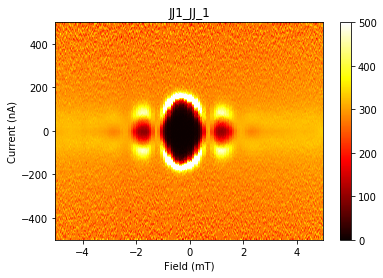

In [9]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('hot')

pixel_width = field[1,0]-field[0,0]
pixel_height = current[0,1]-current[0,0]

im = ax.pcolormesh(1e3*(field-pixel_width/2), 1e9 * (current-pixel_height/2), 
                   R_sm, cmap = cmap, vmin=0,vmax=500)
fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)\
# ax.set_xlim(-2, 2)
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Field (mT)')
plt.title('JJ1_JJ_1')
# plt.savefig('../plots/R(I,B)_JJ1_JJ_1_b.png')
plt.show()

In [10]:
import matplotlib.image as mpimg
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
import matplotlib.colors as colors

In [11]:
import matplotlib

In [12]:
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

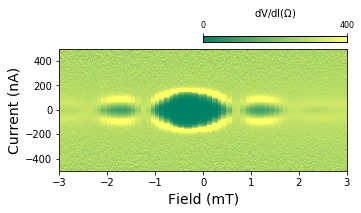

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))

cmap = plt.get_cmap('summer')

pixel_width = field[1,0]-field[0,0]
pixel_height = current[0,1]-current[0,0]

im = ax.pcolormesh(1e3*(field-pixel_width/2), 1e9 * (current-pixel_height/2), 
                   R_sm, cmap = cmap, vmin=0,vmax=400)
# fig.colorbar(im,ax=ax)
# ax.set_ylim(-190, 190)\
ax.set_xlim(-3, 3)
ax.set_ylabel(r'Current (nA)')
ax.set_xlabel(r'Field (mT)')

axins = ax.inset_axes([0.5, 1.05, 0.5, 0.05])

cbar = plt.colorbar(im,
cax=axins,
orientation='horizontal',
ticks = [0, 400],
use_gridspec=True
#drawedges=True
)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.tick_top()
axins.set_xlabel(r'dV/dI($\Omega$)', fontsize = 10)
# cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
axins.tick_params(labelsize = 8)
# plt.title('JJ1_JJ_1')
cbar.outline.set_linewidth(1)
# ax.set_ylim(-2, 2)
# ax.set_xlim(-250, -75)

# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 50))
# start, end = ax.get_ylim()
# ax.yaxis.set_ticks(np.arange(start, end+1, 1))

plt.tight_layout()
# plt.savefig('s5_6.pdf', format='pdf', transparent=True)
plt.savefig('../plots/R(I,B)_JJ1.png', format='png', transparent=True, dpi=300)

plt.show()